In [ ]:
import os
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from typing import Union, List
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 14

## EDA

In [ ]:
def load_data(dataFile:str) -> Union[List, List]:
    df = pd.read_csv(dataFile)
    texts = df['tweet_text'].tolist()
    labels = df['cyberbullying_type'].tolist()
    return texts, labels

In [ ]:
dataFile = 'cyberbullying_tweets.csv'
texts, labels = load_data(dataFile)

In [ ]:
len(texts), len(labels)

(47692, 47692)

In [ ]:
labEncoder = LabelEncoder()
labEncoder.fit(labels)
labelsEncoded = labEncoder.transform(labels)

In [ ]:
df = pd.DataFrame({'text':texts, 'labels':labels})
df

,text,labels
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


In [ ]:
any(df.isna().sum())

False

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    47692 non-null  object
 1   labels  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


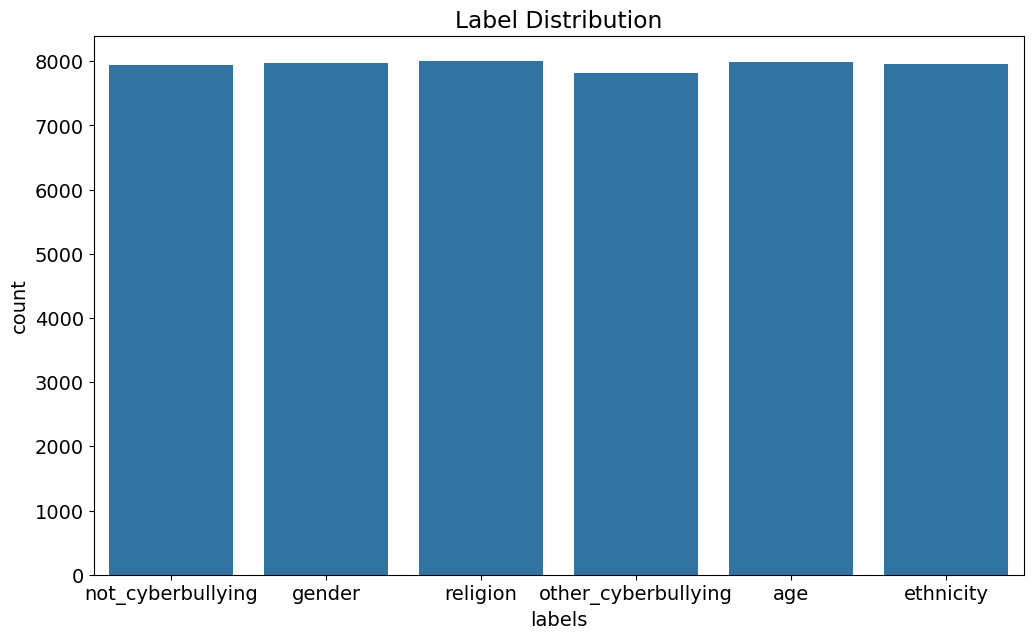

In [ ]:
plt.figure(figsize=(12, 7))
sb.countplot(data=df, x='labels')
plt.title("Label Distribution")
plt.show()

In [ ]:
df.describe()

,text,labels
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


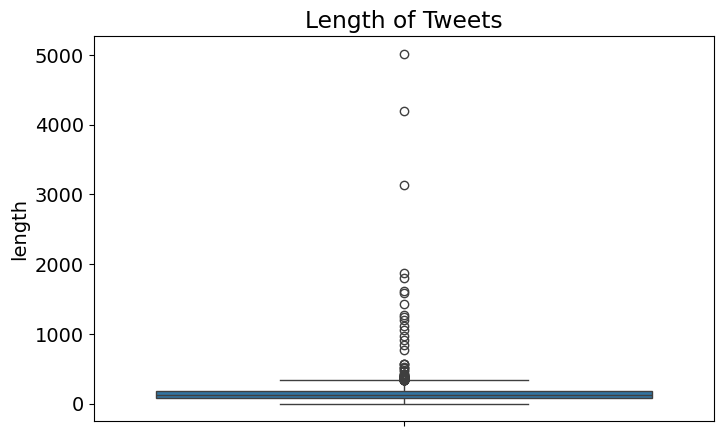

In [ ]:
df['length'] = df['text'].str.len()
sb.boxplot(data=df, y='length')
plt.title("Length of Tweets")
plt.show()

In [ ]:
# le = LabelEncoder()
# df['text'] = le.fit_transform(df['text'])
# df['labels'] = le.fit_transform(df['labels'])
# df.info()

In [ ]:
# df.value_counts()

## Reduce the data

In [ ]:
# IQR = 180.000000 - 78.000000
# lowerB = 78 - 1.5*IQR
# upperB = 180 + 1.5*IQR

<class 'pandas.core.frame.DataFrame'>
Index: 1712 entries, 12 to 47674
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1712 non-null   object
 1   labels  1712 non-null   object
 2   length  1712 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 53.5+ KB


<Axes: ylabel='length'>

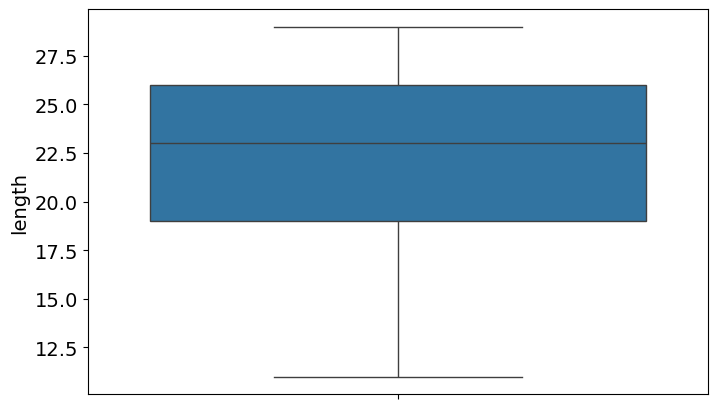

In [ ]:
df = df[((df['length'] > 10)	& (df['length'] < 30))]
df.info()
sb.boxplot(df['length'])

In [ ]:
def word_count(x):
    return len(x.split())

df['word_count'] = df['text'].apply(word_count)

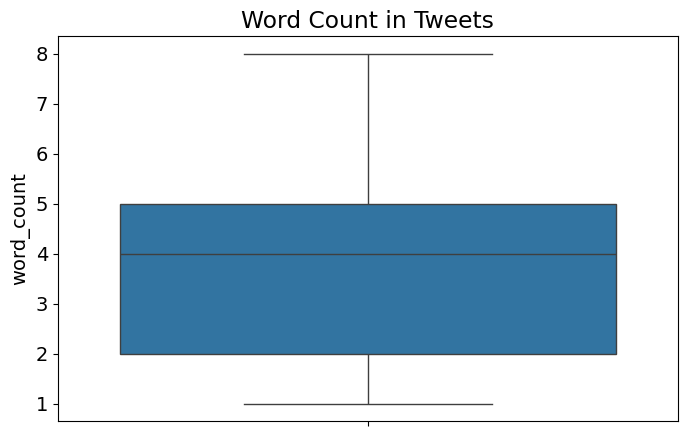

In [ ]:
sb.boxplot(data=df, y='word_count')
plt.title("Word Count in Tweets")
plt.show()

In [ ]:
IQR = 180.000000 - 78.000000
lowerB = 78 - 1.5*IQR
upperB = 180 + 1.5*IQR

## Preprocessing (dataset building)

In [ ]:
class TextClassificationDataset(Dataset):

    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label)
        }

## Modelling

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [ ]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [ ]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = list()
    actual = list()
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual.extend(labels.cpu().tolist())
    return accuracy_score(y_true=actual, y_pred=predictions), classification_report(y_true=actual, y_pred=predictions)

In [ ]:
def predict_class(text, model, tokenizer, device, classes, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

    return classes[preds.item()]

using the best pre-defined parameters

In [ ]:
# bert_model_name = 'bert-base-uncased'
# num_classes = 6
# max_length = 128
# batch_size = 32
# num_epochs = 5
# learning_rate = 2e-5
# fine tuned hyperparameters

bert_model_name = 'bert-base-uncased'
num_classes = 6
max_length = 128
batch_size = 16
num_epochs = 3
learning_rate = 5e-05

In [ ]:
train_texts, val_texts, train_labels, val_labels = tts(texts, labelsEncoded, test_size=0.2, random_state=42)
len(train_texts), len(val_texts), len(train_labels), len(val_labels)

(38153, 9539, 38153, 9539)

In [ ]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer=tokenizer, max_length=max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer=tokenizer, max_length=max_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

## Evaluation metrics

In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train(model, train_dataloader, optimizer, scheduler, device)
    accuracy, report = evaluate(model, val_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

Epoch 1/3
Validation Accuracy: 0.8667
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1603
           1       0.99      0.97      0.98      1603
           2       0.83      0.92      0.87      1531
           3       0.75      0.57      0.65      1624
           4       0.69      0.79      0.73      1612
           5       0.95      0.97      0.96      1566

    accuracy                           0.87      9539
   macro avg       0.87      0.87      0.86      9539
weighted avg       0.87      0.87      0.86      9539

Epoch 2/3
Validation Accuracy: 0.8650
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1603
           1       0.99      0.98      0.99      1603
           2       0.88      0.89      0.89      1531
           3       0.70      0.61      0.65      1624
           4       0.69      0.76      0.72      1612
           5       0.95      0.97      0.96      1566

 